In [6]:
!pip install torchcam

In [65]:
# импорт библиотек
import torch
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torchvision import models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

Инструкция к установке
pip install pandas,
pip install matplotlib,
pip install torch,
pip install torchvision,
pip install pillow,
pip install numpy,
pip install scikit-learn,
pip install torchcam

In [8]:
# задаем преобразование изображений
transform = transforms.Compose([
    transforms.Resize(256),     # преобразование к 256х256
    transforms.CenterCrop(224),        # обрезание до 224х224
    transforms.ToTensor(),             # преобразование в тензор
    transforms.Normalize(              # нормализация
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

Данная трансформация является стандартной для alexnet

In [9]:
class CSVImageDataset(Dataset):
    # инициализируем трансформацию
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    # получение длины
    def __len__(self):
        return len(self.df)
    # преобразуем изображения в тензоры
    def __getitem__(self, idx):
        # получаем путь к изображению из базы данных
        img_path = 'data/images/' + self.df.iloc[idx]
        # трансформируем каждое изображение
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image
    # добавляем все изображения в один тензор
    def to_tensor(self):
        tensor = []
        for i in range(len(self)):
            img_tensor = self[i]
            tensor.append(img_tensor)
        return torch.stack(tensor)

In [10]:
# считываем данные
data = pd.read_csv('data/train.csv')
# X - пути к изображениям, y - класс изображения
X = data['image']
y = data['class']

In [11]:
# разбиваем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1000)

In [12]:
# преобразуем все обьекты в тензоры
X_train = CSVImageDataset(X_train, transform=transform)
X_train = X_train.to_tensor()
X_test = CSVImageDataset(X_test, transform=transform)
X_test = X_test.to_tensor()
y_train = torch.from_numpy(np.array(y_train)).long()
y_test = torch.from_numpy(np.array(y_test)).long()
y_test

tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

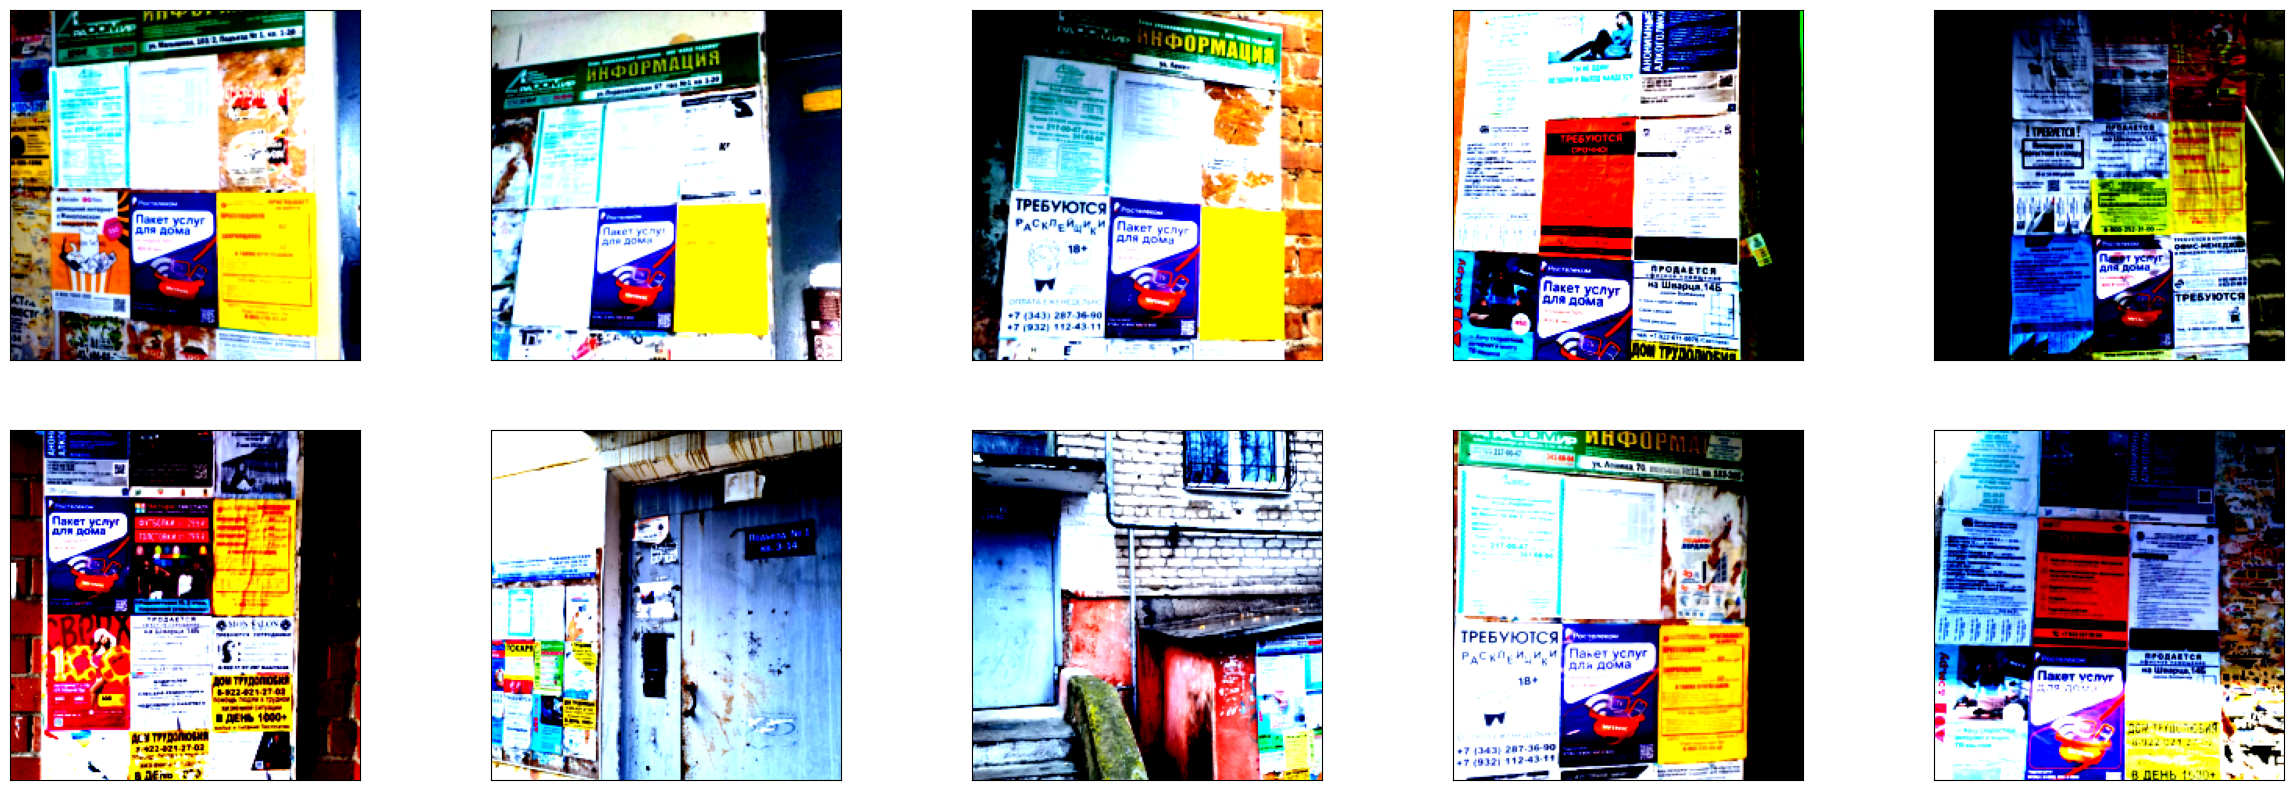

In [13]:
# отображаем часть изображений
hh = 2
ww = 5

fig, ax = plt.subplots(hh, ww, figsize=(30, 5 * hh))

for i, (x, y) in enumerate(zip(X_train, y_train)):
    if i >= hh * ww:
        break
    plt.subplot(hh, ww, i + 1)
    plt.imshow(x.permute(1, 2, 0).clamp(0, 1))
    plt.xticks([])
    plt.yticks([])
plt.show()

Здесь показаны изображения после применения преобразований. Как можно заметить, реклама Ростелекома, если она присутствует на изображении, состоит из плаката, на котором сам значок с названием компании, а также надпись "Пакет услуг для дома" с изображением этого пакета. Данный плакат может находиться в любом месте изображения, поэтому все пиксели важны

In [14]:
# создаем нейронную сеть
class RostelecomNet(torch.nn.Module):
    # инициализируем слои нейронной сети
    def __init__(self):
        super(RostelecomNet, self).__init__()
        # первый сверточный слой
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=2, kernel_size=11, padding=0)
        # функция активации
        self.act1 = torch.nn.Tanh()
        # average pooling слой
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        # второй сверточный слой
        self.conv2 = torch.nn.Conv2d(in_channels=2, out_channels=1, kernel_size=11, padding=0)
        # функция активации
        self.act2 = torch.nn.Tanh()
        # average pooling слой
        self.pool2 = torch.nn.AvgPool2d(kernel_size=4, stride=4)
        # третий сверточный слой
        self.conv3 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=0)
        # функция активации
        self.act3 = torch.nn.Tanh()
        # average pooling слой
        self.pool3 = torch.nn.AvgPool2d(kernel_size=3, stride=3)
        # линейный слой
        self.fc1 = torch.nn.Linear(1 * 6 * 6, 2)
    # функция прямого прохода
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        return x
rostelecomnet = RostelecomNet()

In [15]:
# функция потерь и оптимизатор
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rostelecomnet.parameters(), lr=1.0e-2)

In [18]:
# размер батча
batch_size = 100
# массивы значений функции потерь
losses_train = []
losses_val = []
# процесс обучения
for epoch in range(5000):
    # перемешиваем данные
    order = np.random.permutation(len(X_train))
    # проходимся по батчам
    for start_index in range(0, len(X_train), batch_size):
        # обнуляем градиенты
        optimizer.zero_grad()
        # создаем тензоры батчей
        batch_indexes = order[start_index:start_index+batch_size]
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        # прямой проход
        preds = rostelecomnet.forward(x_batch)
        # значение функции потерь
        loss_value = loss(preds, y_batch)
        # добавление в массив ошибок
        losses_train.append(loss_value.item())
        # обратное распространение ошибки
        loss_value.backward()
        # шаг градиентного спуска
        optimizer.step()
        # для тестовых данных не нужен градиент, поэтому используем обертку
        with torch.no_grad():
            test_preds = rostelecomnet.forward(X_test)
            loss_value = loss(test_preds, y_test)
        losses_val.append(loss_value.item())
    # каждые 10 эпох получаем значение f1-score для тестовых данных
    if epoch % 10 == 0:
        test_preds = test_preds.argmax(dim=1)
        print(f1_score(test_preds, y_test))
        if f1_score(test_preds, y_test) >= 0.95:
            break
# отображаем график ошибок: синяя линия - тренировочные данные, оранжевая - тестовые
plt.plot(losses_train)
plt.plot(losses_val)
plt.show()


0.8951048951048951
0.8951048951048951


KeyboardInterrupt: 

Данная модель является моей самой первой идеей. Гиперпараметры взяты случайные, их можно видеть в коде. Я ожидал, что она покажет намного худший результат, но в итоге результат получился относительно неплохим. После я продолжил подбор гиперпараметров

In [19]:
# аналогично предыдущей модели
class RostelecomNet(torch.nn.Module):
    def __init__(self):
        super(RostelecomNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=11, padding=0)
        self.act1 = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=11, padding=0)
        self.act2 = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=4, stride=4)
        self.conv3 = torch.nn.Conv2d(in_channels=16, out_channels=2, kernel_size=5, padding=0)
        self.act3 = torch.nn.Tanh()
        self.pool3 = torch.nn.AvgPool2d(kernel_size=3, stride=3)
        self.fc1 = torch.nn.Linear(2 * 6 * 6, 50)
        self.act4 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(50, 2)
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.fc2(x)
        return x
rostelecomnet = RostelecomNet()

In [20]:
# аналогично предыдущей модели
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rostelecomnet.parameters(), lr=1.0e-3)

In [21]:
# аналогично предыдущей модели
batch_size = 100
losses_train = []
losses_val = []
for epoch in range(5000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        preds = rostelecomnet.forward(x_batch)
        loss_value = loss(preds, y_batch)
        losses_train.append(loss_value.item())
        loss_value.backward()
        optimizer.step()
        with torch.no_grad():
            test_preds = rostelecomnet.forward(X_test)
            loss_value = loss(test_preds, y_test)
        losses_val.append(loss_value.item())
    if epoch % 10 == 0:
        test_preds = test_preds.argmax(dim=1)
        print(f1_score(test_preds, y_test))
        if f1_score(test_preds, y_test) >= 0.975:
            break
plt.plot(losses_train)
plt.plot(losses_val)
plt.show()



0.8961038961038961


KeyboardInterrupt: 

Спустя несколько неудачных попыток, были подобраны гиперпараметры, которые значительно улучшили результат, однако этого было недостаточно, и я продолжил подбор

In [22]:
# перенос обучения
weights = models.AlexNet_Weights.DEFAULT # переносим веса из предобученной модели
rostelecomnet = models.alexnet(weights=weights) # создаем предобученную модель
print(rostelecomnet)
for param in rostelecomnet.parameters(): # замораживаем веса
    param.requires_grad = False
# переопределяем последний линейный слой
rostelecomnet.classifier[6] = torch.nn.Linear(rostelecomnet.classifier[6].in_features, 2)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 149MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
# аналогично предыдущим моделям
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(rostelecomnet.parameters(), lr=1.0e-2)

0.8961038961038961
0.9784172661870504
0.9784172661870504
0.9855072463768116
0.9855072463768116
0.9928057553956835
0.9855072463768116
0.9855072463768116
0.9928057553956835
0.9855072463768116
0.9855072463768116
0.9928057553956835
0.9784172661870504
0.9928057553956835
0.9857142857142858
0.9857142857142858
0.9855072463768116
0.9784172661870504
0.9928057553956835
1.0


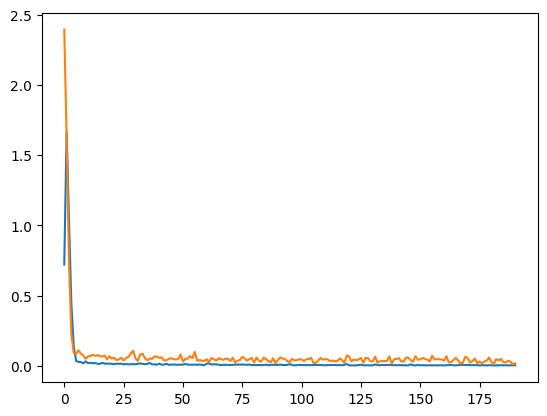

In [24]:
# аналогично предыдущим моделям
batch_size = 253
losses_train = []
losses_val = []
for epoch in range(5000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        preds = rostelecomnet.forward(x_batch)
        loss_value = loss(preds, y_batch)
        losses_train.append(loss_value.item())
        loss_value.backward()
        optimizer.step()
        with torch.no_grad():
            test_preds = rostelecomnet.forward(X_test)
            loss_value = loss(test_preds, y_test)
        losses_val.append(loss_value.item())
    if epoch % 10 == 0:
        test_preds = test_preds.argmax(dim=1)
        print(f1_score(test_preds, y_test))
        if f1_score(test_preds, y_test) >= 0.995:
            break
plt.plot(losses_train)
plt.plot(losses_val)
plt.show()


После огромного количества неудачных попыток я решил попробовать использовать перенос обучения с модели alexnet, и хоть он значительно увеличил время обучения, но зато дает огромную точность бинарной классификации. Конечно, в реальности модель не может  идеально все классифицировать, но если здесь максимальный результат(маловероятно переобучение, так как тестовые данные модель не видела), то и в реальной жизни модель будет отлично решать поставленную задачу

In [25]:
# функция для предсказаний
def predict(net, x):
    y_pred = net.forward(x)
    y_pred = y_pred.argmax(dim=1)
    return y_pred

In [26]:
# получаем базу с тестовыми изображениями и преобразуем их в тензор
for param in rostelecomnet.parameters(): # размораживаем веса
    param.requires_grad = True
test_data = pd.read_csv('data/test.csv')
images = test_data['image']
test = CSVImageDataset(images, transform=transform)
test = test.to_tensor()

In [41]:
# получаем предсказания и сохраняем их в файл для отправки
y_preds = predict(rostelecomnet, test)

test_data['class'] = y_preds.detach().numpy()
test_data.to_csv('data/submit.csv')
y_preds

tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])

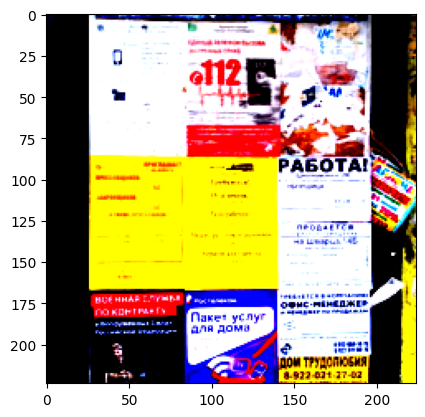

In [86]:
# создание экстрактора grad-cam
cam_extractor = GradCAM(rostelecomnet, target_layer="features.12")
# получение тепловых карт
activation_map = cam_extractor(int(y_preds[1]), rostelecomnet.forward(test))
# оригинальное изображение
plt.imshow(test[1].permute(1, 2, 0).clamp(0, 1).detach().numpy())
plt.show()


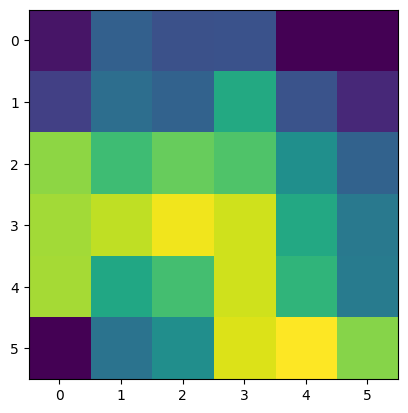

In [87]:
# тепловая карта
plt.imshow(activation_map[0][0])

По итогам интерпретации результатов у нас получилась данная тепловая карта. Более яркие места находятся снизу и справа, следовательно, модель при предсказании опирается на эти места, что логично, ведь во многих изображения реклама находилась в них.